# Income Prediction

Objective of this project is to use classification models to predict if a person's income is less than or greater than 50K

## Dataset

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

#### Load the dataset

In [2]:
# Load the dataset
columns =['age', 'workclass', 'fnlwgt', 'education', 'educationnum','maritalstatus', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'nativecountry','income']
adult = pd.read_csv("../ProjectData/adult/adult.data", header=None, names = columns)
print(adult.shape)
adult.head()

(32561, 15)


age          workclass  fnlwgt   education  educationnum  \
0   39          State-gov   77516   Bachelors            13   
1   50   Self-emp-not-inc   83311   Bachelors            13   
2   38            Private  215646     HS-grad             9   
3   53            Private  234721        11th             7   
4   28            Private  338409   Bachelors            13   

         maritalstatus          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capitalgain  capitalloss  hoursperweek   nativecountry  income  
0         2174            0            40   United-States   <=50K  
1            0            0            13   United-States   <=50K  
2            0            0            40   United-States   <=50K  
3            0            0            40   United-States   <=50K  
4            0            0            40            Cuba   <=50K

Number of categorical variables : 9  
Number of numerical variables:  6

In [3]:
num_features =['age','fnlwgt','educationnum','capitalgain', 'capitalloss', 'hoursperweek']
cat_features =['workclass', 'education', 'maritalstatus', 'occupation', 'relationship', 'race', 'sex', 'nativecountry']
target_feature = ['income']

1. The dataset has a total of 32561 records
2. The dataset has 14 independent variable and one dependent variable
3. The dataset has 8 categorical features - workclass, education, marital-status, occupation, relationship, race, sex, native-country
4. The dataset has 6 numerical features - age,fnlwgt,education-num,capital-gain, capital-loss, hours-per-week
5. Age -   
6. workclass -   
7. fnlwgt -
8. education -
9. education-num -
10. marital-status -
11. occupation -
12. relationship -
13. race -
14. sex -
15. capital-gain -
16. capital-loss -
17. hours-per-week -
18. native-country -  
19. income - This is the target column to predict. Takes value >=50K or <=50K


## Data Cleaning & Data Preparation

#### Encoding Categorical Variables

In [4]:
# Encoding Categorical Variables
def encode_columns(df, cat_features):
    df_encoded = df.copy()  # Create a copy of the DataFrame to work on
    le = LabelEncoder()
    for col in cat_features:
        df_encoded[col] = le.fit_transform(df_encoded[col])  # Convert to string to handle any type of data
    #df_encoded[target_col] = le.fit_transform(df_encoded[target_col])  # Encode the target column
    return df_encoded

# Encode the categorical and target columns
adult_encoded = encode_columns(adult, cat_features + target_feature)

#### Handling Noise and Missing data

In [38]:
#Strip leading and trailing whitespace from all columns
data = adult.map(lambda x: x.strip() if isinstance(x, str) else x)
# Replace '?' with NaN and remove rows with NaN values
adult_clean = data.replace('?', pd.NA).dropna()

In [6]:
adult_clean = encode_columns(adult_clean, cat_features + target_feature)
adult_clean.shape

(30162, 15)

The resampling is done to balance the income resonse variable class. the data is highly imbalanced with major proportion of target variable having income less than 50K
https://arxiv.org/pdf/1106.1813


#### Handling Outliers

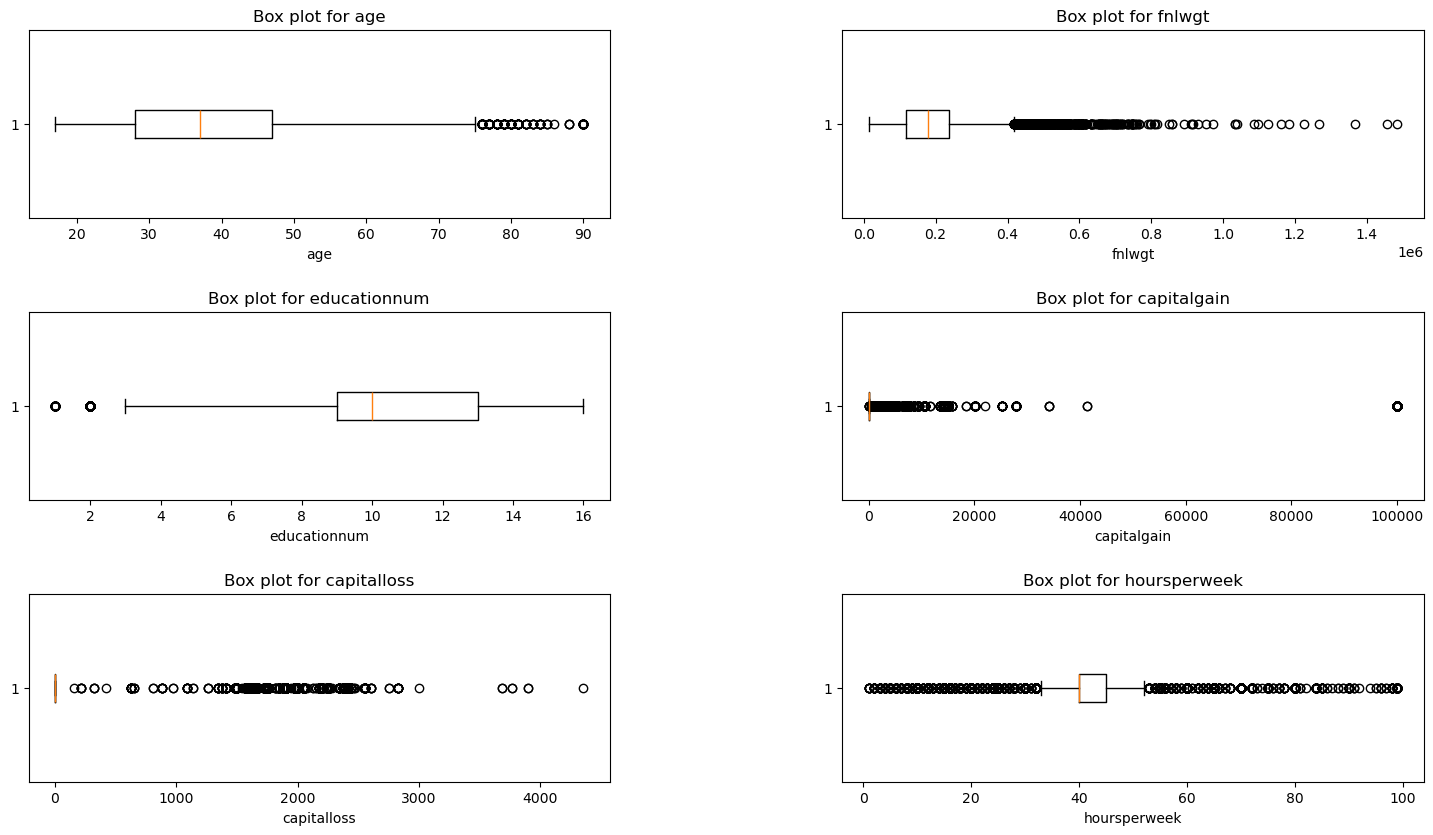

In [7]:
# box plot to detect outliers
# create side by side plots for KDE and bar plot
fig, ax = plt.subplots(3, 2, figsize=(18, 8))
plt.subplots_adjust(top = 0.99, bottom=0.05, hspace=0.5, wspace=0.4)
ax = ax.flatten()
for i,col in enumerate(num_features):
    ax[i].set_title(f'Box plot for {col}')
    ax[i].set_xlabel(col)
    ax[i].boxplot(adult_clean[col], vert=False) 
    
plt.savefig('outlier.png')    
plt.show()
    

In [8]:
# Method to remove outliers using z-score method

def removeOutliersUsingZscore(df, col):
    df_no_outliers = df.assign(zscore_outlier = zscore(df[col]))
    outliers = df_no_outliers[(df_no_outliers['zscore_outlier'] > 3)]
    df_no_outliers = df_no_outliers[(df_no_outliers['zscore_outlier'] < 3)]
    print(f'Number of outliers in {col} using z-score: {len(outliers)}')
    return df_no_outliers

In [9]:
# Removing outliers using z-score method
adult_clean_no_outliers = adult_clean
outliers_IQR = adult_clean
cols=['capitalgain','capitalloss']
for col in cols:
    adult_clean_no_outliers = removeOutliersUsingZscore(adult_clean_no_outliers,col)
    
print('\n')
print("Outliers identified using Z-score method: ", len(adult_clean_no_outliers))

Number of outliers in capitalgain using z-score: 198
Number of outliers in capitalloss using z-score: 1381


Outliers identified using Z-score method:  28583


In [10]:
adult_clean_no_outliers.drop('zscore_outlier', axis=1, inplace=True)

#### Resampling due to imbalance in dataset

In [11]:
# Encoding the outlier cleaned data
adult_clean = encode_columns(adult_clean_no_outliers, cat_features + target_feature)
adult_clean.shape

(28583, 15)

In [12]:
# Resampling using SMOTE
# Apply SMOTE to the training data only
X = adult_clean.drop('income', axis=1)
y = adult_clean['income']

# SMOTE resampling
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# concat the two datasets
adult_smote = pd.concat([X_smote, y_smote], axis=1)
print(f'Shape of the resampled data: {adult_smote.shape}')

Shape of the resampled data: (44006, 15)


## Exploratory Data Analysis

### Univariate Analysis

In [13]:
# Descriptive statistics for adult dataset
adult.describe()

age        fnlwgt  educationnum   capitalgain   capitalloss  \
count  32561.000000  3.256100e+04  32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05     10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05      2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04      1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05      9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05     10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05     12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06     16.000000  99999.000000   4356.000000   

       hoursperweek  
count  32561.000000  
mean      40.437456  
std       12.347429  
min        1.000000  
25%       40.000000  
50%       40.000000  
75%       45.000000  
max       99.000000

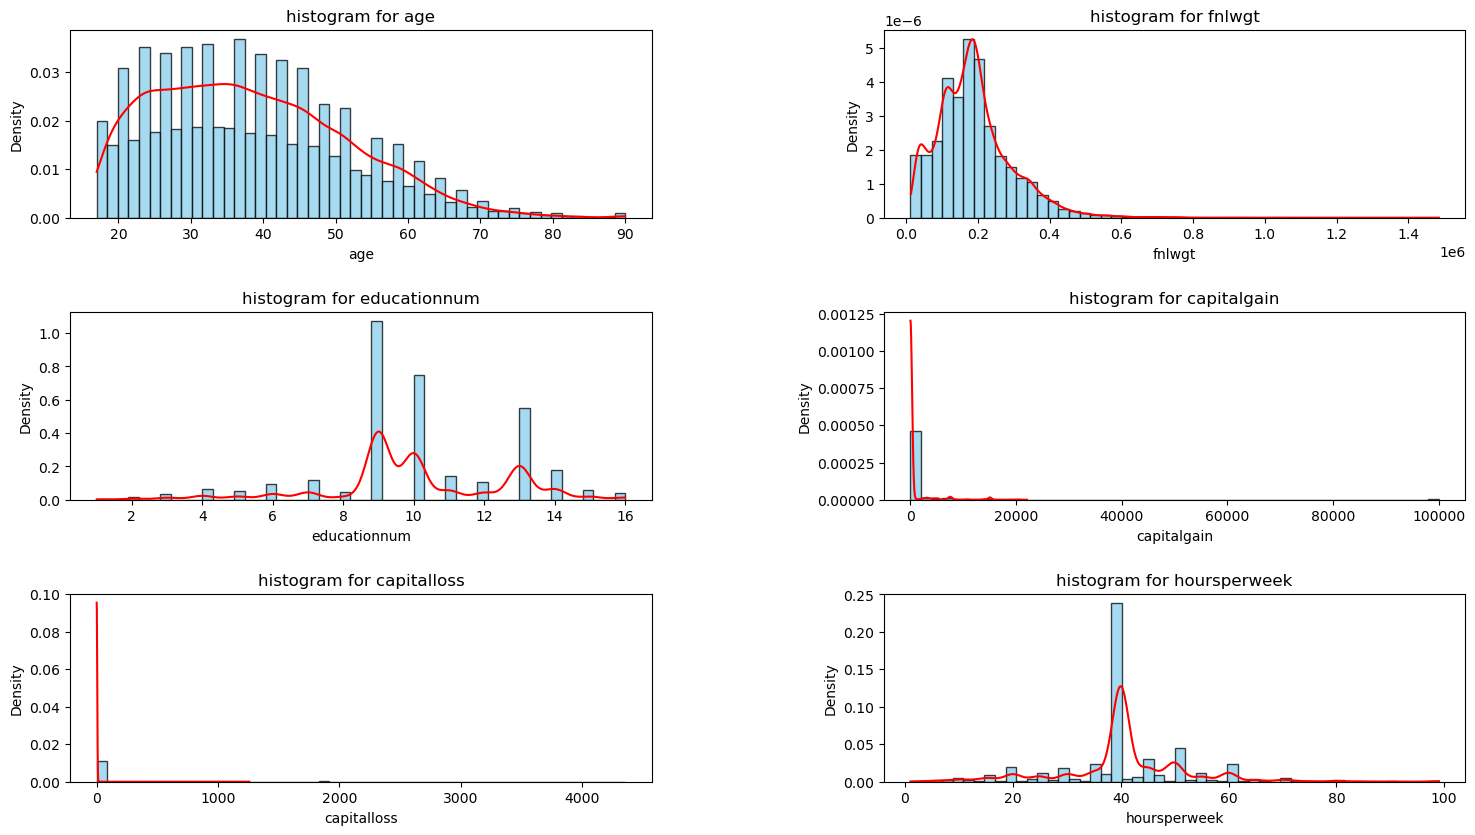

In [14]:
# create histogram with KDE plot for all teh numerical features
fig, ax = plt.subplots(3, 2, figsize=(18, 8))
plt.subplots_adjust(top = 0.99, bottom=0.05, hspace=0.5, wspace=0.4)
ax = ax.flatten()
for i,col in enumerate(num_features):
    kde = stats.gaussian_kde(adult_clean[col])
    x = np.linspace(adult_clean[col].min(), adult_clean[col].max(), 1000)
    ax[i].plot(x, kde(x), color='red')
    ax[i].hist(adult[col], bins=50, density=True, alpha=0.75, color='skyblue', edgecolor='black')
    ax[i].set_title(f'histogram for {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Density')

plt.savefig('num_hist.png')
#fig.delaxes(ax[i+1])

#### Analysis of numberical columns

1. Age is positively skewed with mean slightly greater than median
2. Fnlwgt: Fnlwgt is significantly skewed to right with Kurtosis value of 6.6 and skewness value of 1.5
3. Captial gain: with high skewness value and very high kurtosis value, ths shows capital gain is heavily skewed to right with significant outliers. The Q1, median, and Q3 are all 0, indicating that the majority of the data points are 0
4. Captial loss: with high skewness value and very high kurtosis value, ths shows capital gain is heavily skewed to right with significant outliers. The Q1, median, and Q3 are all 0, indicating that the majority of the data points are 0
5. The hours per week is only slightly skewed and mostly follows a normal distribution

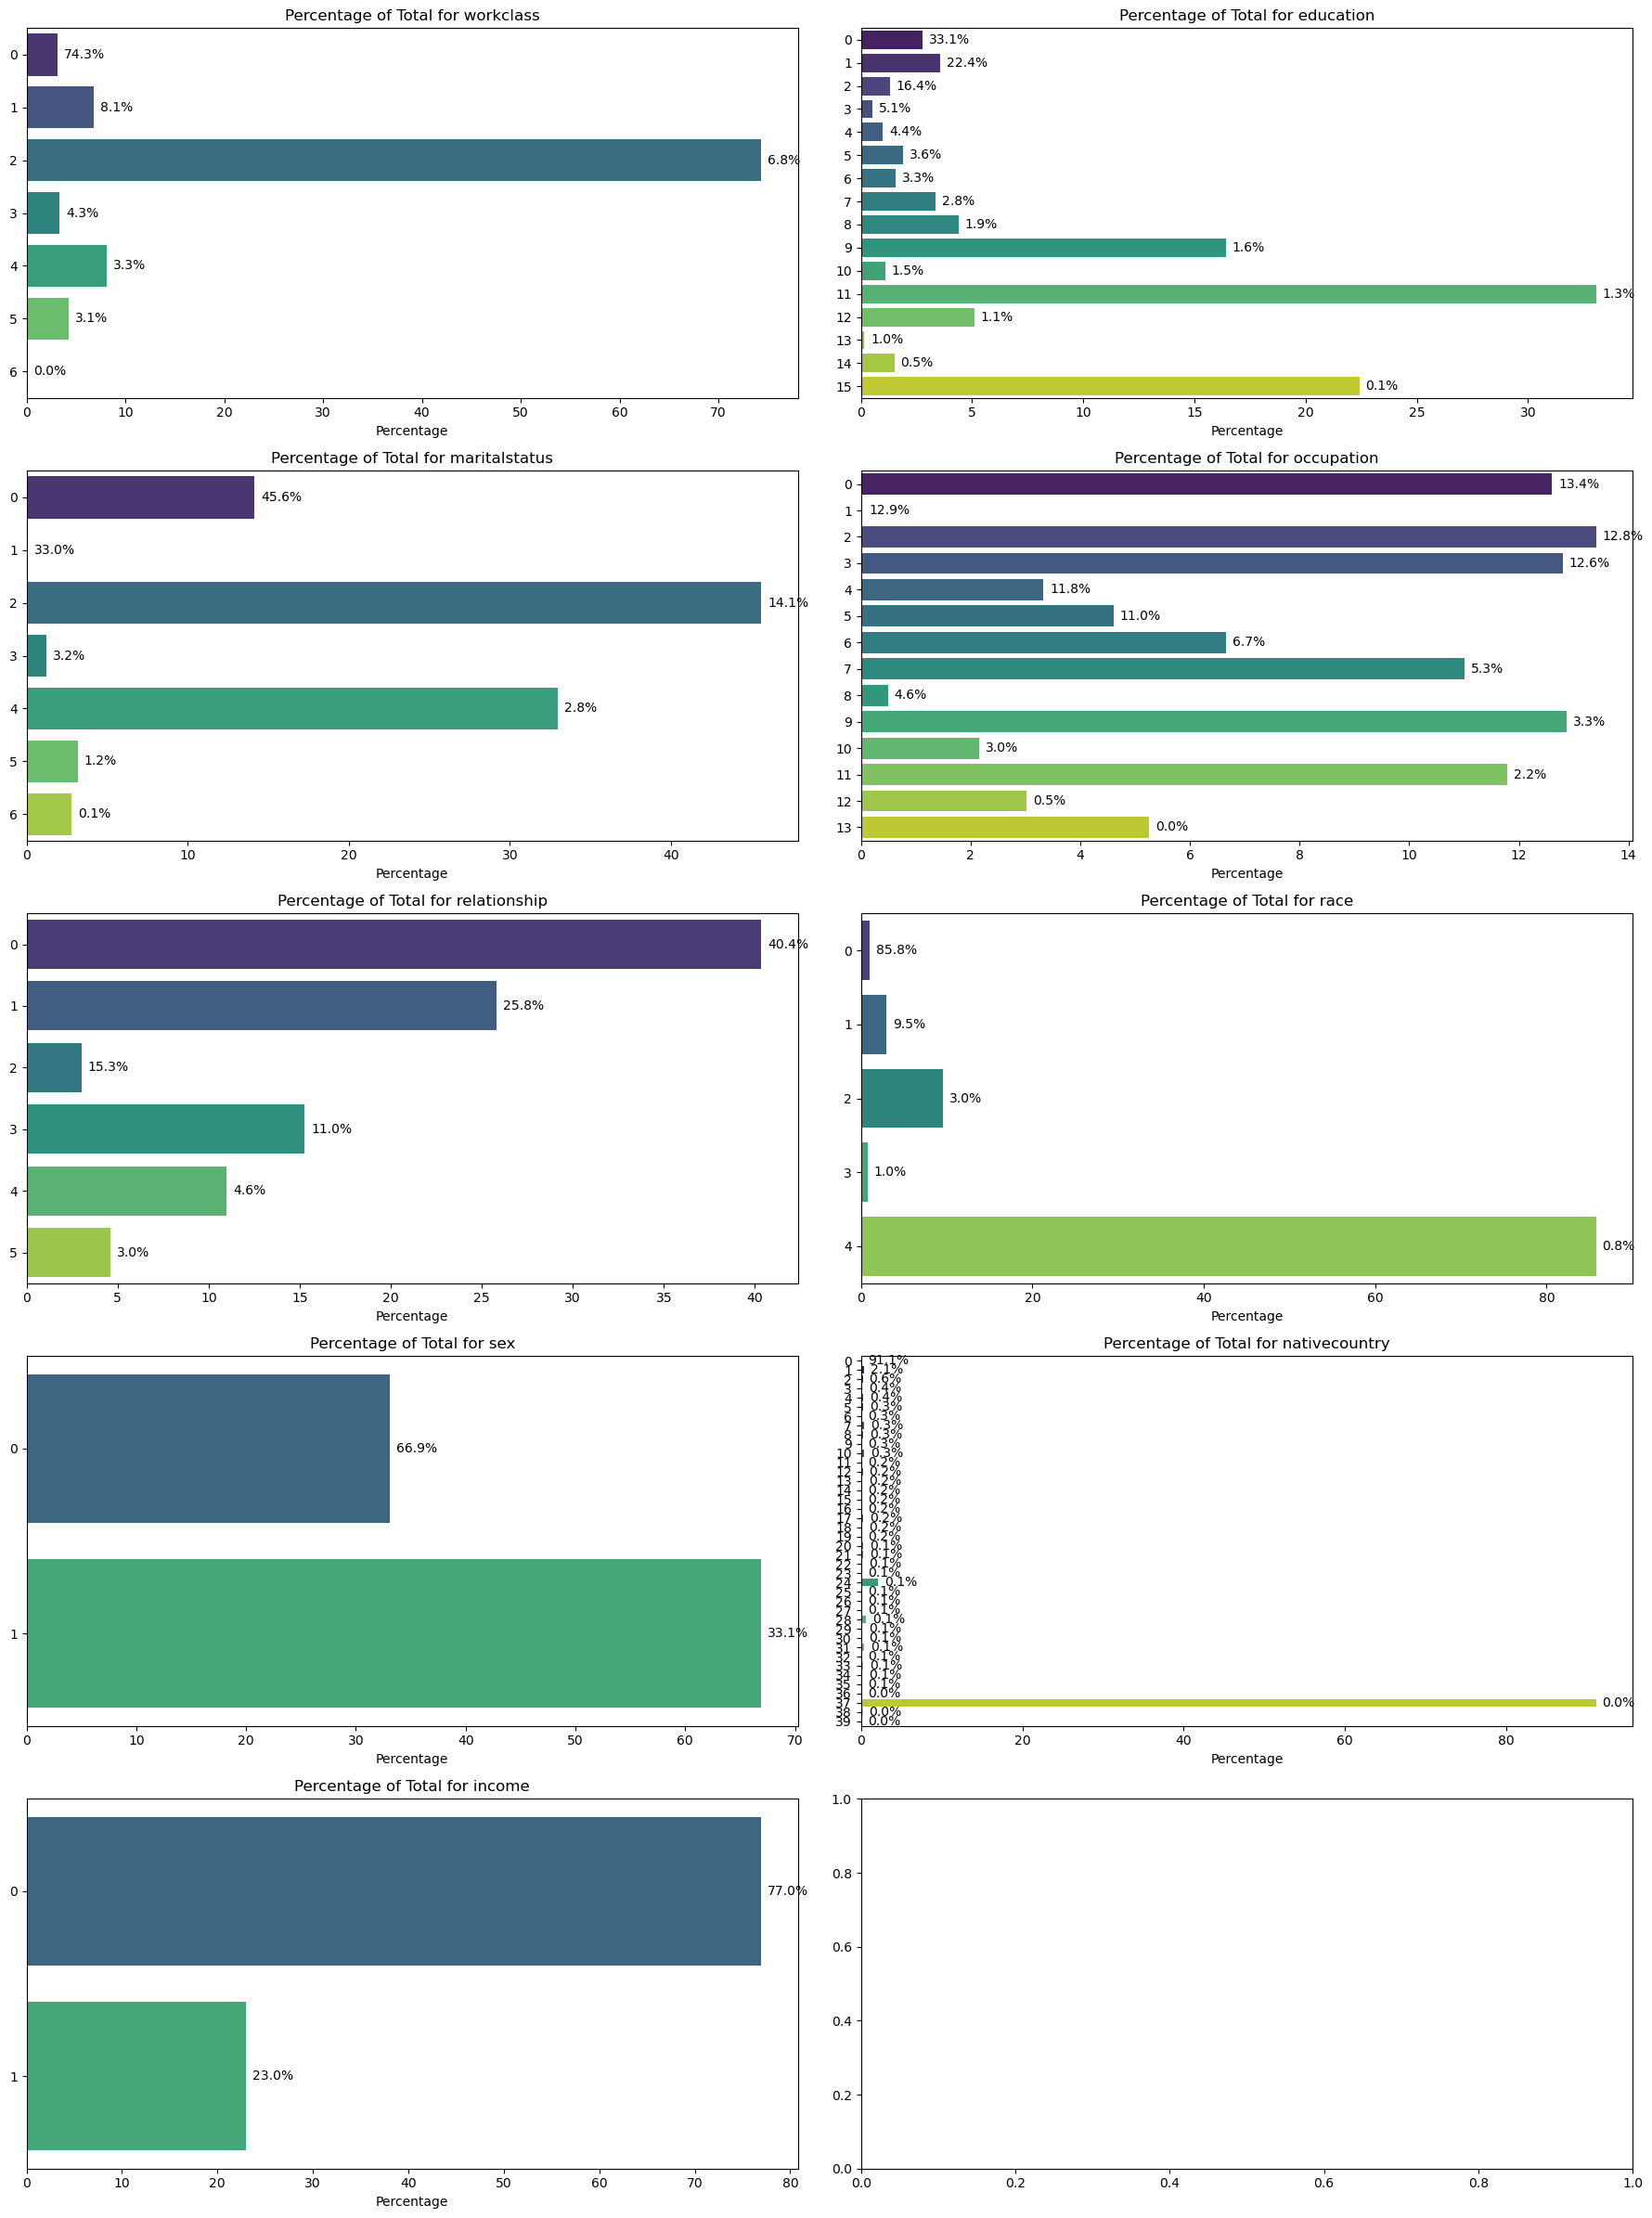

In [15]:
# find the percentage of category for each variable
def percent_of_total(df, second_column):
    value_counts = df[second_column].value_counts()
    percent_total = value_counts/sum(value_counts)
    return percent_total*100
    
# Setting up the subplots
#fig, ax = plt.subplots(9, 2, figsize=(18, 24), gridspec_kw={'width_ratios': [2, 1]})
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 24))
axes = axes.flatten()

# Plotting horizontal bar plots
for ax, col in zip(axes, cat_features+target_feature):
    percent_total = percent_of_total(adult_clean, col)
    bars = sns.barplot(x=percent_total.values, y=percent_total.index, data=adult_clean, ax=ax, palette='viridis',orient='h')
    
    # Annotating the bars with percentage values
    for bar, perc in zip(bars.patches, percent_total.values):
        ax.annotate(f'{perc:.1f}%',
                    xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                    xytext=(5, 0),  # 5 points horizontal offset
                    textcoords='offset points',
                    ha='left', va='center')
    
    ax.set_title(f'Percentage of Total for {col}')
    ax.set_xlabel('Percentage')
    ax.set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.savefig('cat_univariate')
plt.show()

1. Private workclass category represents 70% proportion of the total dataset
2. 90% proportion of total dataset has data for United states. Other countries has relatively small proportion of data.
3. Distribution of rest of the categories are highly fragmented, with no dominant category

# Bivariate Analysis

#### Bivariate analysis of Categorical features vs Income 

/var/folders/5s/p_hsrlds037bkqzzfx_qb0_00000gn/T/ipykernel_1265/461277247.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9030662710187932' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  percent_of_total.iloc[i,:] = percent_of_total.iloc[i,:]/sum(percent_of_total.iloc[i,:])
/var/folders/5s/p_hsrlds037bkqzzfx_qb0_00000gn/T/ipykernel_1265/461277247.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09693372898120672' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  percent_of_total.iloc[i,:] = percent_of_total.iloc[i,:]/sum(percent_of_total.iloc[i,:])
/var/folders/5s/p_hsrlds037bkqzzfx_qb0_00000gn/T/ipykernel_1265/461277247.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future vers

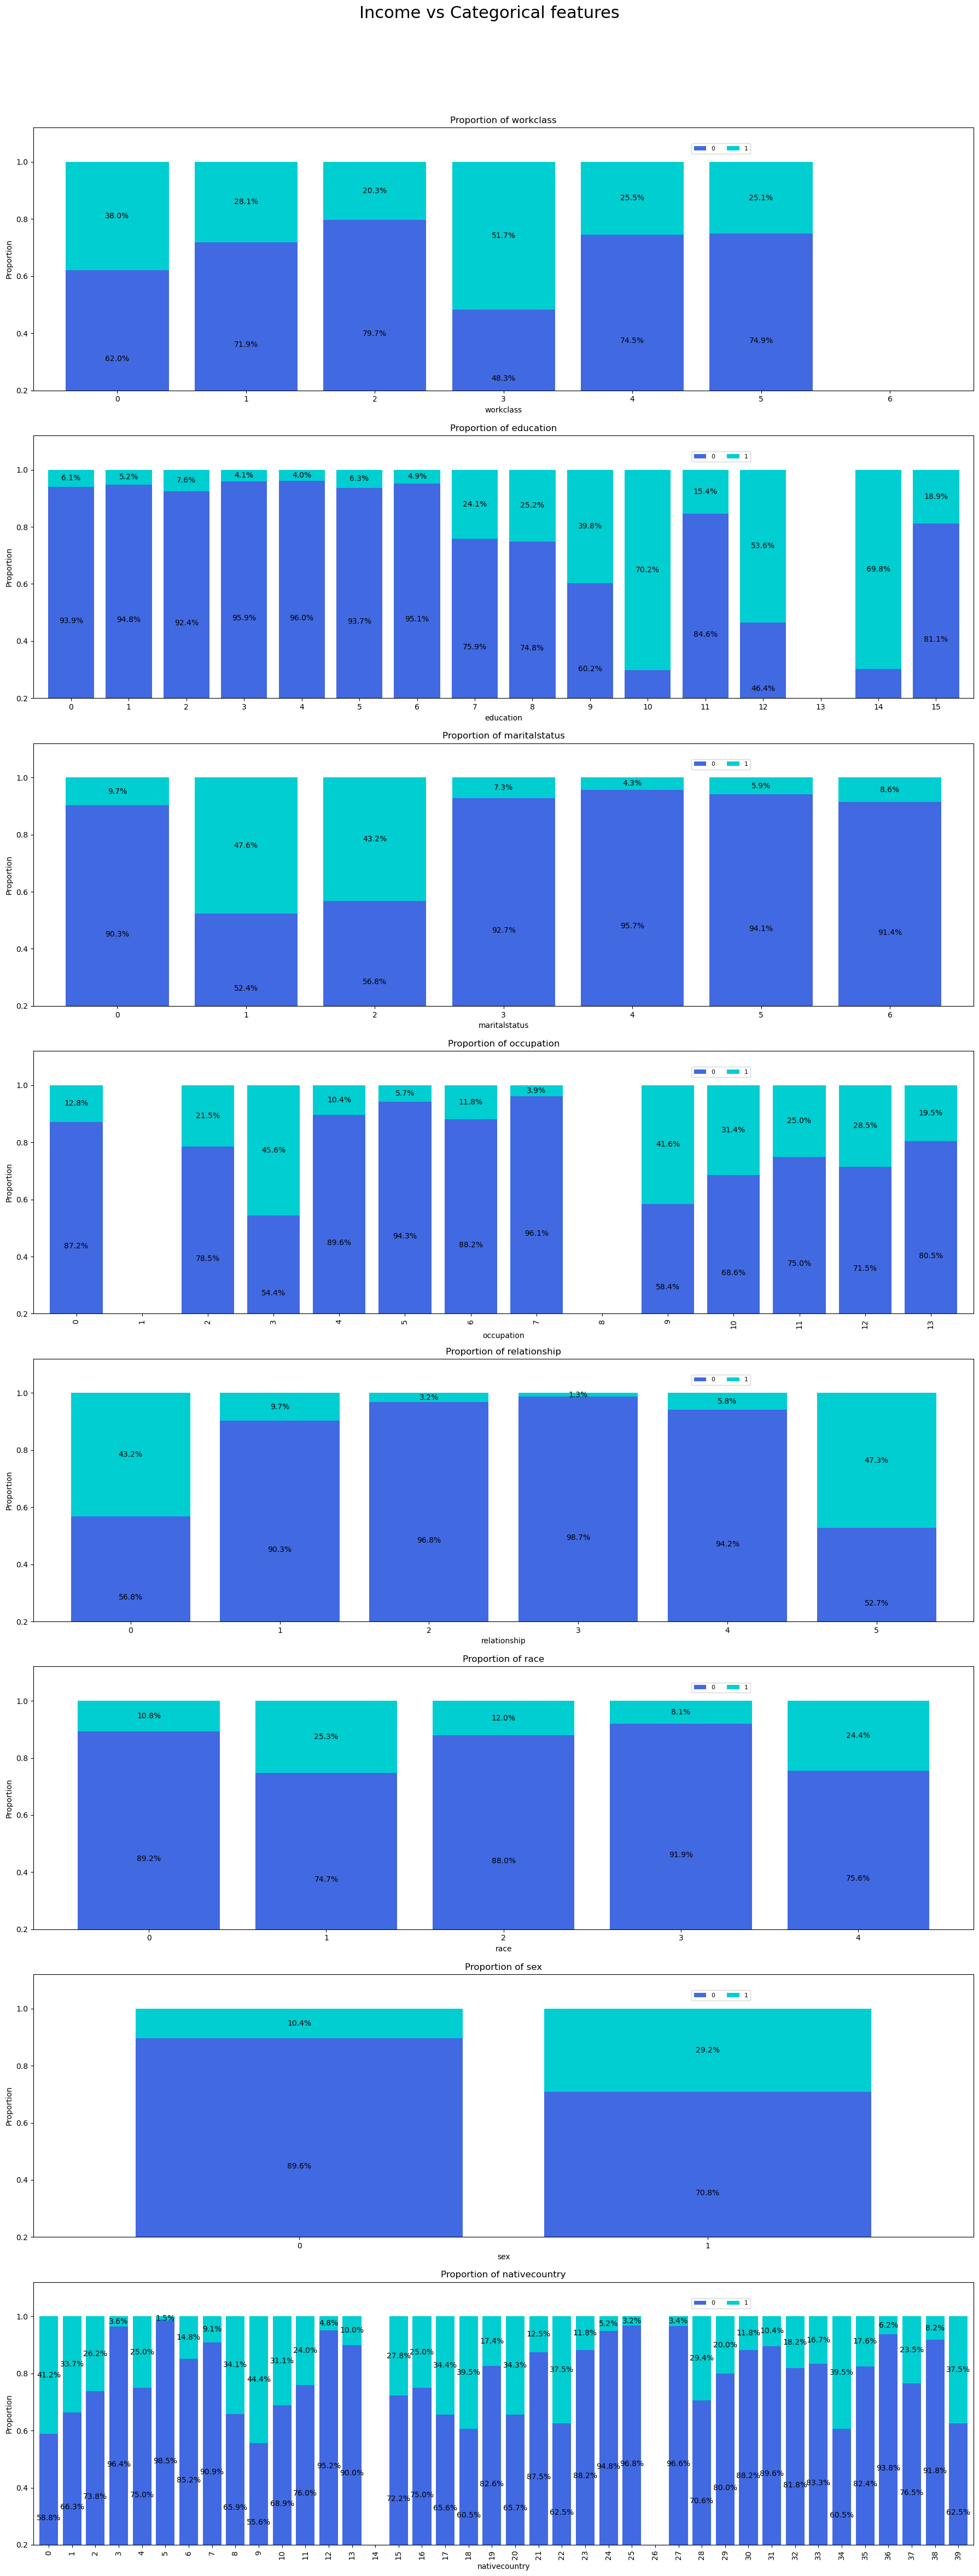

In [16]:
# calculate proportion for each colunmn
def calculateProportion(column):
    percent_of_total = adult_clean.groupby([column, target_feature[0]]).size().unstack()
    for i in range(len(percent_of_total)):
        percent_of_total.iloc[i,:] = percent_of_total.iloc[i,:]/sum(percent_of_total.iloc[i,:])
    return percent_of_total


fig, ax = plt.subplots(8, 1, figsize=(18, 48))
ax = ax.flatten()
cmp = ListedColormap(['royalblue', 'darkturquoise'])
for i,col in enumerate(cat_features):
    proportion = calculateProportion(col)
    bars = proportion.plot(kind='bar', ax=ax[i], stacked=True, width=0.8, colormap=cmp, legend=False, ylabel='Proportion', sharey=True)
    for bar_container in bars.containers:
        for bar in bar_container:
            height = bar.get_height()
            ax[i].annotate(f'{height:.1%}',
                           xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                           xytext=(0, 0),  # No offset
                           textcoords="offset points",
                           ha='center', va='center', fontsize=10, color='black')
    ax[i].set_title(f'Proportion of {col}')
    ax[i].legend(loc=(0.7, 0.9), fontsize=8, ncol=2)
    ax[i].set_ylim([0.2, 1.12])
    rotation = 90 if i==7 or i==3 else 0
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=rotation)

plt.suptitle('Income vs Categorical features', fontsize=22)
#plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('cat_bivariate.png')

plt.show()

1. Around 75% of the dataset has data about individuals earning <50K. The dataset is highly imbalanced.  
2. Individuals working in the private sector represent a significant proportion of the dataset. Only self-employed individuals have a higher proportion of income than 50K.  
3. The majority of individuals earning higher incomes are those who have done Master's, Doctor's, or professional school. The majority of those earning lower incomes are schoolers.   
4. 86% of the dataset consists of White compared to other race  
5. Proportion of male is double that of female.  

#### Bivariate analysis of Nuerical features vs Income 

/var/folders/5s/p_hsrlds037bkqzzfx_qb0_00000gn/T/ipykernel_1265/517776768.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_income_group = adult_num_hist.groupby([f'{col}_group', 'income']).size().unstack().fillna(0)
/var/folders/5s/p_hsrlds037bkqzzfx_qb0_00000gn/T/ipykernel_1265/517776768.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_income_group = adult_num_hist.groupby([f'{col}_group', 'income']).size().unstack().fillna(0)
/var/folders/5s/p_hsrlds037bkqzzfx_qb0_00000gn/T/ipykernel_1265/517776768.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True 

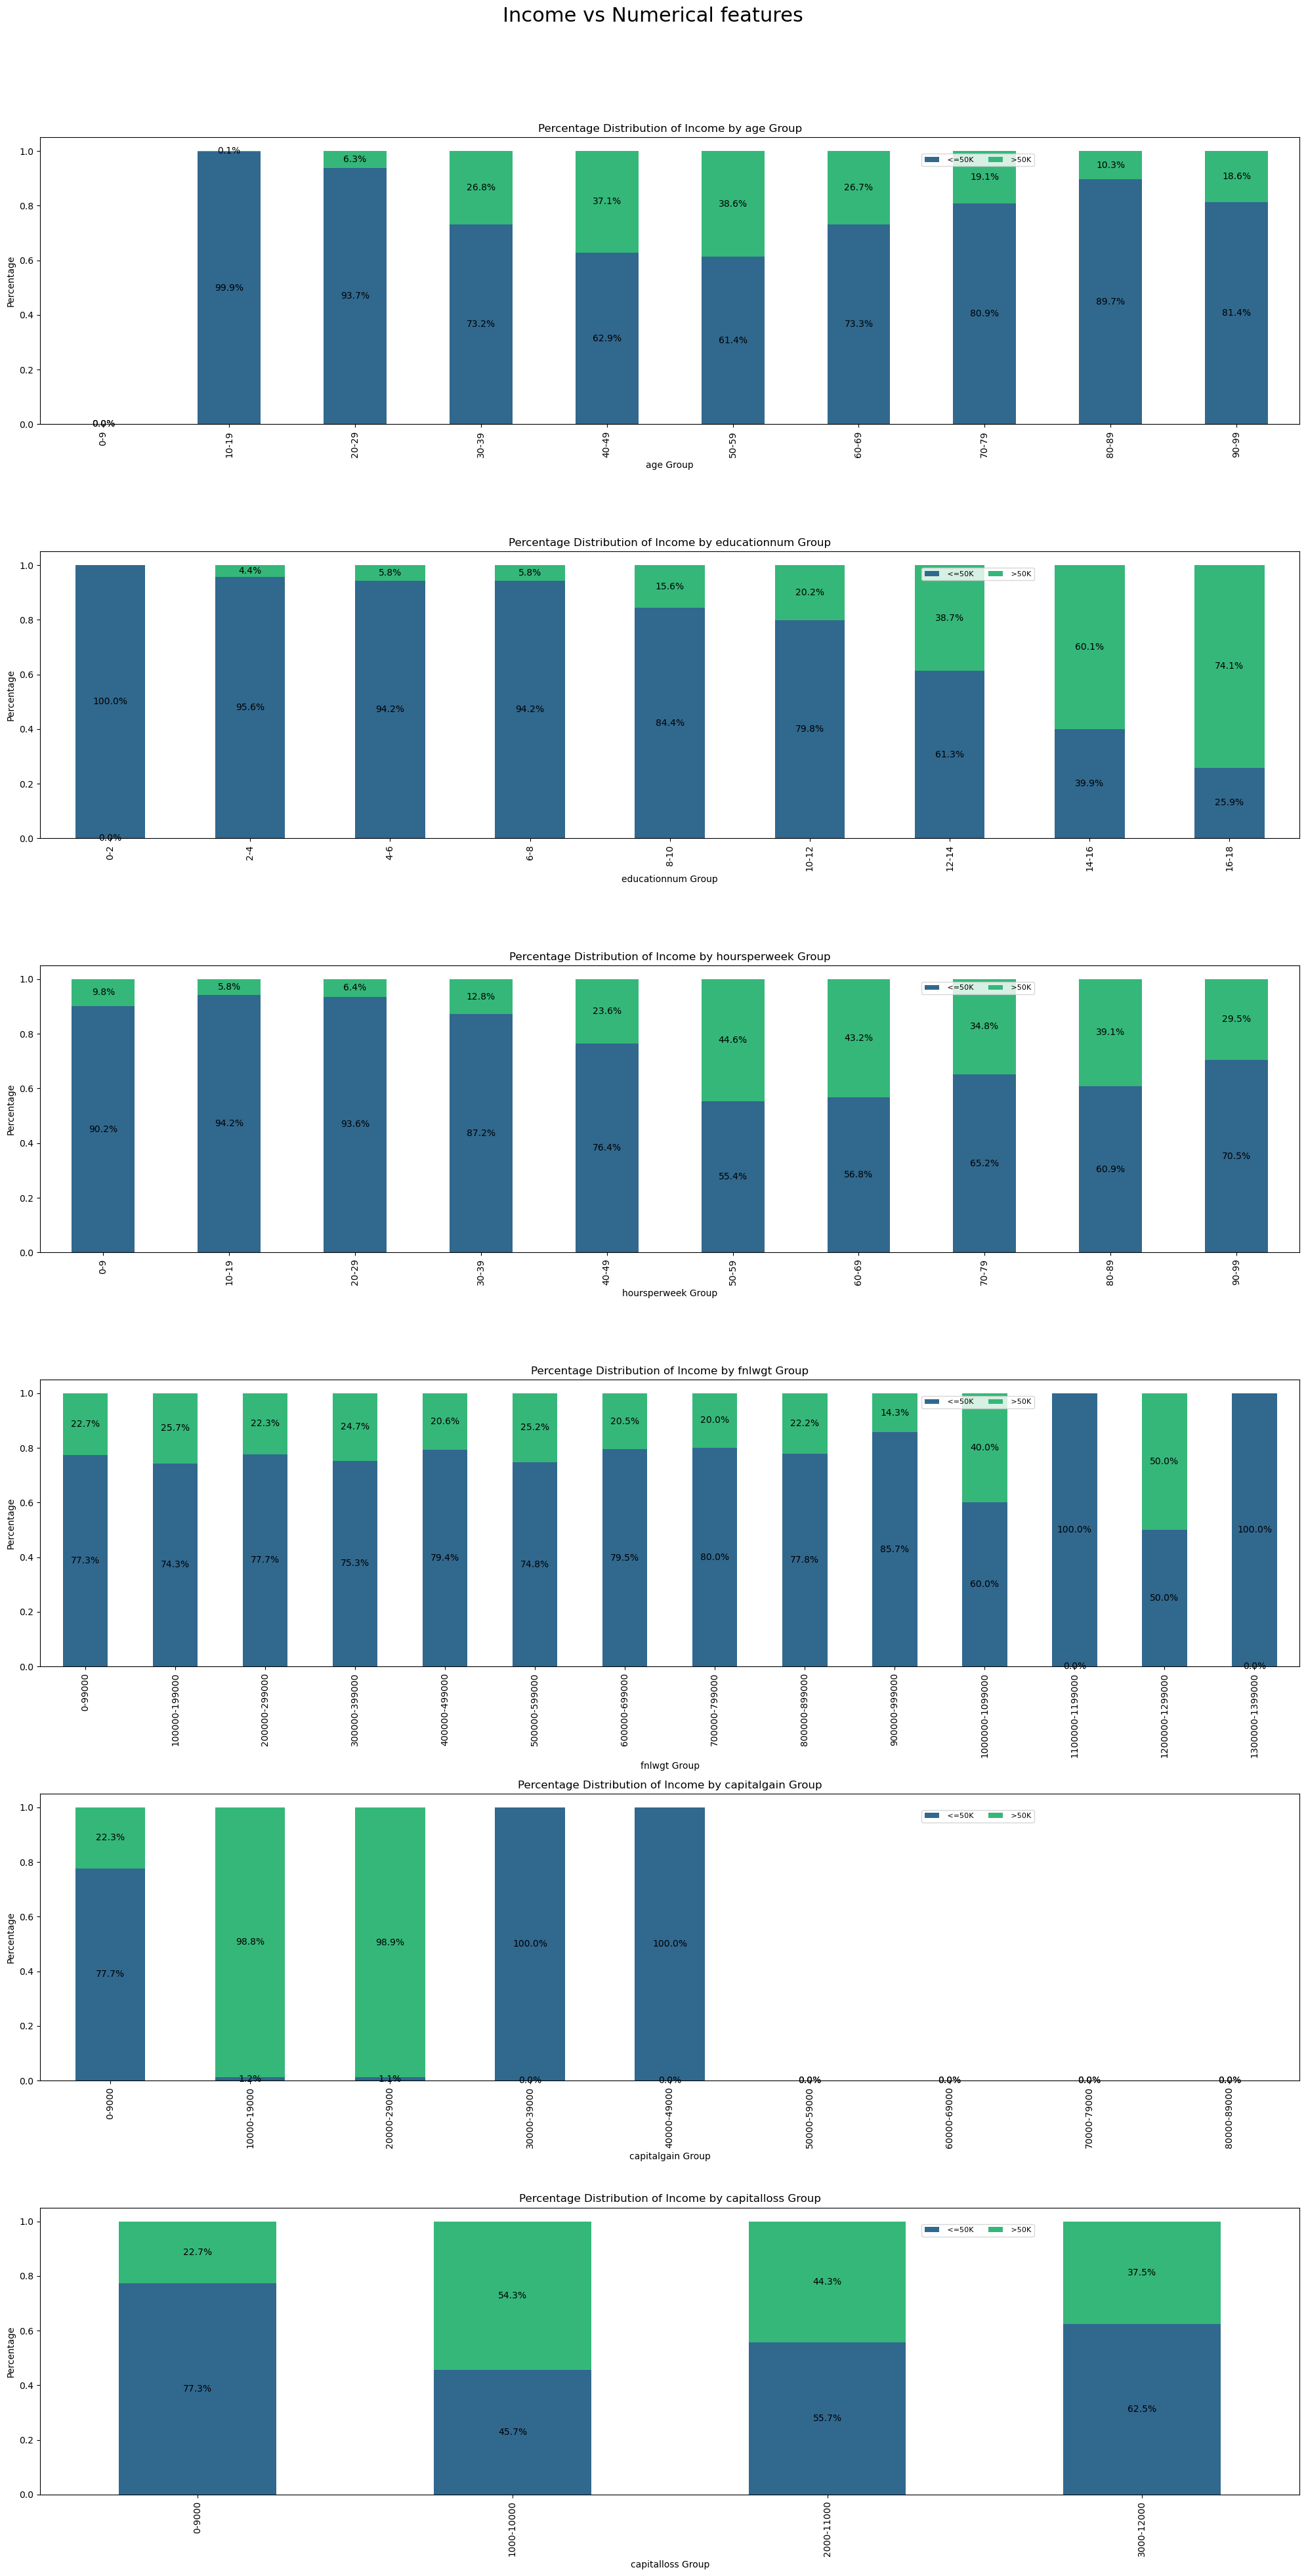

In [17]:
adult_num_hist = adult
fig, ax = plt.subplots(6, 1, figsize=(20, 40))
ax = ax.flatten()
num_cols = {'age': 10, 'educationnum': 10,'hoursperweek': 10, 'fnlwgt':100000, 'capitalgain':1000, 'capitalloss':1000}
keys_enum = enumerate(num_cols)
for i, col in keys_enum:
    
    # Define age bins and labels
    bins = range(0, 101, num_cols[col])  # Bins from 0 to 100 in intervals of 10
    labels = [f'{i}-{i+9}' for i in bins[:-1]]  # Create labels for bins
    
    # Customizing sample intervals for numerica features
    if (col=='educationnum'):
        bins = range(0, 20, 2) 
        labels = [f'{i}-{i+2}' for i in bins[:-1]]  # Create labels for bins
    elif (col=='fnlwgt'):
        bins = range(0, 1500000, 100000) 
        labels = [f'{i}-{i+99000}' for i in bins[:-1]]  # Create labels for bins
    elif (col=='capitalgain'):
        bins = range(0, 100000, 10000) 
        labels = [f'{i}-{i+9000}' for i in bins[:-1]]  # Create labels for bins
    elif (col=='capitalloss'):
        bins = range(0, 5000, 1000) 
        labels = [f'{i}-{i+9000}' for i in bins[:-1]]  # Create labels for bins
    
    # Group ages into bins
    adult_num_hist[f'{col}_group'] = pd.cut(adult_num_hist[col], bins=bins, labels=labels, right=False)
    
    # Calculate the percentage of each age group within each income category
    age_income_group = adult_num_hist.groupby([f'{col}_group', 'income']).size().unstack().fillna(0)
    age_income_group_percent = age_income_group.div(age_income_group.sum(axis=1), axis=0) 
    
    # Create a stacked bar plot for age groups and income
    bars = age_income_group_percent.plot(kind='bar', stacked=True, color=sns.color_palette('viridis', len(age_income_group.columns)), ax=ax[i])
    for bar_container in bars.containers:
        for bar in bar_container:
            height = bar.get_height()
            ax[i].annotate(f'{height:.1%}',
                           xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                           xytext=(0, 0),  # No offset
                           textcoords="offset points",
                           ha='center', va='center', fontsize=10, color='black')
    ax[i].legend(loc=(0.7, 0.9), fontsize=8, ncol=2)
    ax[i].set_xticklabels(ax[i].get_xticklabels())    
                          
    # Add labels and title
    ax[i].set_xlabel(f'{col} Group')
    ax[i].set_ylabel('Percentage')
    ax[i].set_title(f'Percentage Distribution of Income by {col} Group')

plt.suptitle('Income vs Numerical features', fontsize=22)
#plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('num_bivariate.png')
plt.show()


1. The age data is a bit skewed, with individuals between the ages of 17-20 and 80-90 having a very small proportion of income >50K  
2. The income increases with the number of years of experience. The proportion of individuals above 14 years of experience are earning income >50K  
3. Most of the capital gains and losses have a value of 0, with some extreme values.  
4. Individuals working on an average of 45 hours per week or above earn income > 50K  


/Users/karthikvishwanathraghavan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/karthikvishwanathraghavan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/karthikvishwanathraghavan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/karthikvishwanathraghavan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

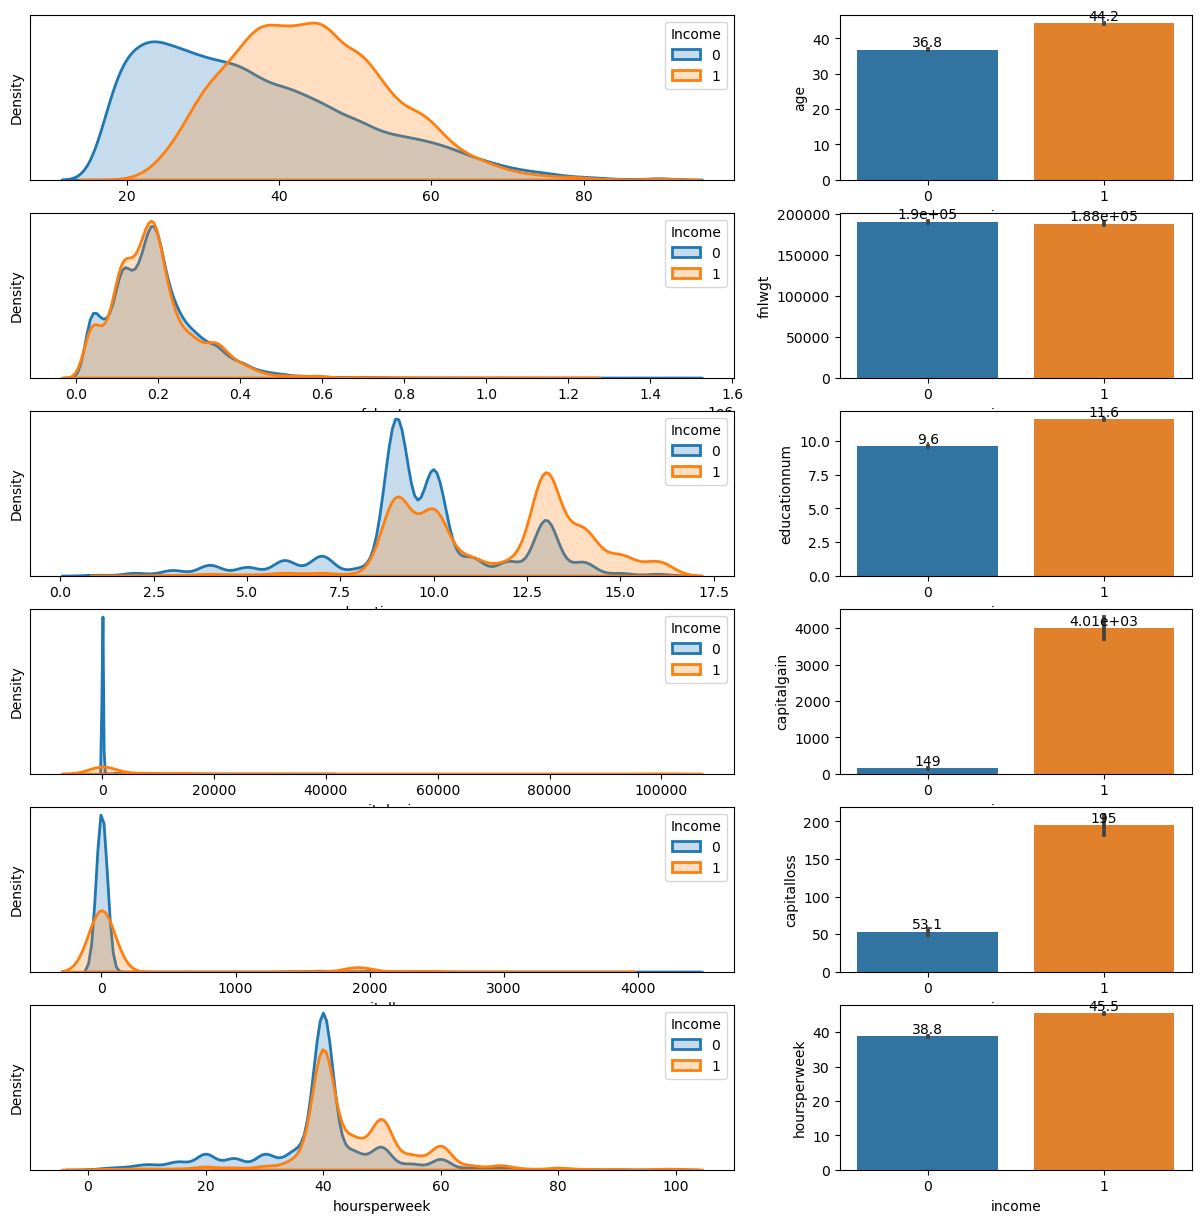

In [18]:
# Function for KDE plot
def kdeplot(col, color):
    kde = stats.gaussian_kde(adult_encoded[col].dropna())
    x = np.linspace(adult_encoded[col].min(), income[col].max(), 1000)
    ax[i,0].plot(x, kde(x), color=color)

# Replace infinite values with NaN
adult_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)

# create side by side plots for KDE and bar plot
fig, ax = plt.subplots(6, 2, figsize=(15, 15), gridspec_kw={'width_ratios': [2, 1]})
for i,col in enumerate(num_features):
    # KDE plot of numerical features
    sns.kdeplot(data=adult_encoded[adult_encoded[target_feature[0]]==0], x=col, fill=True, linewidth=2, ax=ax[i,0], label='0')
    sns.kdeplot(data=adult_encoded[adult_encoded[target_feature[0]]==1], x=col, fill=True, linewidth=2, ax=ax[i,0], label='1')

    # Correspnding proportion of the numerical feature
    proportion = calculateProportion(col)
    graph = sns.barplot(data=adult_encoded, x=target_feature[0], y=col, ax=ax[i,1])

    # Annotate each bar with its value
    # Add values at the center of the bars
    for cont in graph.containers:
        graph.bar_label(cont, fmt='%.3g')
    
    ax[i,0].set_yticks([])
    ax[i,0].legend(title='Income', loc='upper right')

plt.savefig('num_hist-bar.png')

#### Bivariate analysis - Correnation between features

In [19]:
# Find correlations between income and other features
correlations = adult_clean.corr()['income'].abs()
correlations

age              0.233847
workclass        0.007457
fnlwgt           0.009422
education        0.075351
educationnum     0.316152
maritalstatus    0.189427
occupation       0.047080
relationship     0.245595
race             0.070363
sex              0.210240
capitalgain      0.339763
capitalloss      0.016917
hoursperweek     0.218683
nativecountry    0.022337
income           1.000000
Name: income, dtype: float64

In [20]:
adult_clean.corr()

age  workclass    fnlwgt  education  educationnum  \
age            1.000000   0.074907 -0.078352  -0.005679      0.032105   
workclass      0.074907   1.000000 -0.035369   0.015444      0.033784   
fnlwgt        -0.078352  -0.035369  1.000000  -0.026975     -0.047701   
education     -0.005679   0.015444 -0.026975   1.000000      0.349639   
educationnum   0.032105   0.033784 -0.047701   0.349639      1.000000   
maritalstatus -0.276680  -0.030699  0.032715  -0.038665     -0.057130   
occupation    -0.007516   0.015277 -0.004153  -0.039721      0.083394   
relationship  -0.244878  -0.068489  0.011170  -0.010281     -0.086200   
race           0.021541   0.044411 -0.023170   0.011133      0.030697   
sex            0.076990   0.073785  0.024078  -0.031434     -0.001121   
capitalgain    0.129882   0.016394 -0.002901   0.027648      0.152426   
capitalloss    0.018439  -0.007601 -0.001114  -0.002828      0.007331   
hoursperweek   0.098528   0.048907 -0.024565   0.057960      0.142075   
nativecountry -0.001659   0.008826 -0.068898   0.082425      0.096759   
income         0.233847   0.007457 -0.009422   0.075351      0.316152   

               maritalstatus  occupation  relationship      race       sex  \
age                -0.276680   -0.007516     -0.244878  0.021541  0.076990   
workclass          -0.030699    0.015277     -0.068489  0.044411  0.073785   
fnlwgt              0.032715   -0.004153      0.011170 -0.023170  0.024078   
education          -0.038665   -0.039721     -0.010281  0.011133 -0.031434   
educationnum       -0.057130    0.083394     -0.086200  0.030697 -0.001121   
maritalstatus       1.000000    0.023790      0.177194 -0.067278 -0.115677   
occupation          0.023790    1.000000     -0.052641  0.001189  0.064006   
relationship        0.177194   -0.052641      1.000000 -0.118521 -0.579663   
race               -0.067278    0.001189     -0.118521  1.000000  0.090727   
sex                -0.115677    0.064006     -0.579663  0.090727  1.000000   
capitalgain        -0.064482    0.015289     -0.089404  0.023743  0.071465   
capitalloss        -0.013171   -0.001647      0.032886  0.000296 -0.029834   
hoursperweek       -0.186465    0.016012     -0.252999  0.047671  0.226298   
nativecountry      -0.025270   -0.001729     -0.010593  0.119399  0.000249   
income             -0.189427    0.047080     -0.245595  0.070363  0.210240   

               capitalgain  capitalloss  hoursperweek  nativecountry    income  
age               0.129882     0.018439      0.098528      -0.001659  0.233847  
workclass         0.016394    -0.007601      0.048907       0.008826  0.007457  
fnlwgt           -0.002901    -0.001114     -0.024565      -0.068898 -0.009422  
education         0.027648    -0.002828      0.057960       0.082425  0.075351  
educationnum      0.152426     0.007331      0.142075       0.096759  0.316152  
maritalstatus    -0.064482    -0.013171     -0.186465      -0.025270 -0.189427  
occupation        0.015289    -0.001647      0.016012      -0.001729  0.047080  
relationship     -0.089404     0.032886     -0.252999      -0.010593 -0.245595  
race              0.023743     0.000296      0.047671       0.119399  0.070363  
sex               0.071465    -0.029834      0.226298       0.000249  0.210240  
capitalgain       1.000000    -0.009147      0.091573       0.011729  0.339763  
capitalloss      -0.009147     1.000000     -0.002646       0.001826 -0.016917  
hoursperweek      0.091573    -0.002646      1.000000       0.010110  0.218683  
nativecountry     0.011729     0.001826      0.010110       1.000000  0.022337  
income            0.339763    -0.016917      0.218683       0.022337  1.000000

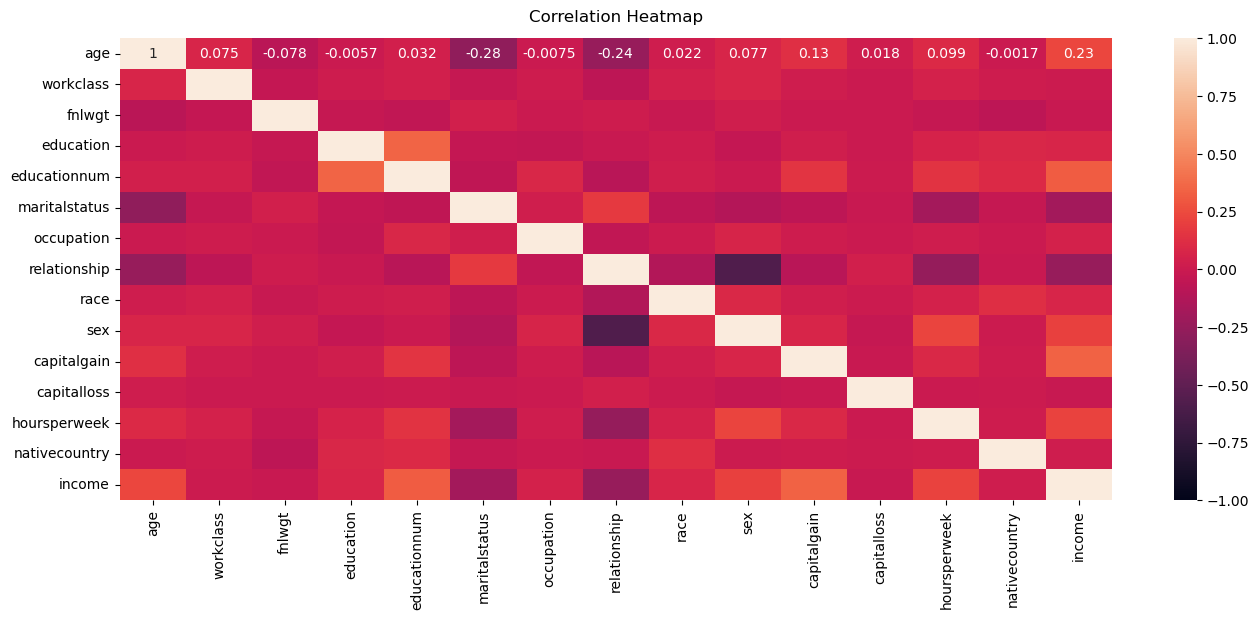

In [21]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
heatmap = sns.heatmap(adult_clean.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e  
https://towardsdatascience.com/seaborn-heatmap-for-visualising-data-correlations-66cbef09c1fe

1. Number of years of education and captial gain has a strong positive correlation against income.
2. age, ccapital-loss,and hours-per-week has moderate positive correlations and has a significant role in determining the income
4. Education, occupation, race, workclass, native-country has a weak positive correlation
5. Relationship, marital-status has weak correlations. This suggests that certain marital statuses or relationship types may be associated with slightly lower incomes.
6. Fnlwgt has very weak negative correlation and may not have any inflluence on income.

https://matplotlib.org/3.5.0/tutorials/intermediate/gridspec.html

### Model & Feature Selection

#### Generalized Linear Model

In [22]:
# Bonferroni approach to find the significance value
# significance level
alpha = 0.05 

# number of tests conducted 
m = 14        

# Bonferroni approach
apha_adj = alpha/m 

print(f'Adjusted significance level using Bonferroni approach: {apha_adj:.4f}')

Adjusted significance level using Bonferroni approach: 0.0036


In [23]:
def trainGLM(df):
    return smf.glm(formula='income ~ workclass+education+maritalstatus+occupation+relationship+race+sex+nativecountry+age+fnlwgt+educationnum+capitalgain+capitalloss+hoursperweek', family=sm.families.Binomial(), data=df).fit().summary()

In [24]:
trainGLM(adult_encoded)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 income   No. Observations:                32561
Model:                            GLM   Df Residuals:                    32546
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12480.
Date:                Sun, 23 Jun 2024   Deviance:                       24960.
Time:                        19:57:28   Pearson chi2:                 1.61e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2864
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.3708      0.191    -43.829      0.000      -8.745      -7.996
workclass        -0.0217      0.011     -1.930      0.054      -0.044       0.000
education         0.0158      0.005      3.053      0.002       0.006       0.026
maritalstatus    -0.2346      0.012    -19.154      0.000      -0.259      -0.211
occupation        0.0106      0.004      2.724      0.006       0.003       0.018
relationship     -0.1195      0.014     -8.353      0.000      -0.147      -0.091
race              0.1134      0.021      5.322      0.000       0.072       0.155
sex               0.8954      0.050     17.795      0.000       0.797       0.994
nativecountry     0.0034      0.002      1.605      0.109      -0.001       0.008
age               0.0341      0.001     25.197      0.000       0.031       0.037
fnlwgt         5.095e-07   1.52e-07      3.346      0.001    2.11e-07    8.08e-07
educationnum      0.3315      0.007     45.938      0.000       0.317       0.346
capitalgain       0.0003   9.76e-06     32.407      0.000       0.000       0.000
capitalloss       0.0007   3.36e-05     20.222      0.000       0.001       0.001
hoursperweek      0.0299      0.001     21.412      0.000       0.027       0.033
=================================================================================
"""

In [25]:
trainGLM(adult_clean)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 income   No. Observations:                28583
Model:                            GLM   Df Residuals:                    28568
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10993.
Date:                Sun, 23 Jun 2024   Deviance:                       21985.
Time:                        19:57:28   Pearson chi2:                 2.82e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2665
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.1862      0.211    -38.807      0.000      -8.600      -7.773
workclass        -0.1368      0.017     -8.029      0.000      -0.170      -0.103
education         0.0187      0.006      3.371      0.001       0.008       0.030
maritalstatus    -0.2261      0.013    -17.319      0.000      -0.252      -0.200
occupation       -0.0006      0.004     -0.150      0.880      -0.009       0.008
relationship     -0.1310      0.015     -8.568      0.000      -0.161      -0.101
race              0.1222      0.023      5.310      0.000       0.077       0.167
sex               0.9319      0.054     17.360      0.000       0.827       1.037
nativecountry     0.0003      0.003      0.085      0.933      -0.006       0.006
age               0.0370      0.001     24.938      0.000       0.034       0.040
fnlwgt         5.169e-07   1.61e-07      3.203      0.001    2.01e-07    8.33e-07
educationnum      0.3360      0.008     43.103      0.000       0.321       0.351
capitalgain       0.0003   1.06e-05     31.828      0.000       0.000       0.000
capitalloss      -0.0024      0.001     -2.316      0.021      -0.004      -0.000
hoursperweek      0.0295      0.002     19.274      0.000       0.026       0.032
=================================================================================
"""

#### Feature Engineering

In [26]:
correlations = adult_clean.corr()['income'].abs()
correlations

age              0.233847
workclass        0.007457
fnlwgt           0.009422
education        0.075351
educationnum     0.316152
maritalstatus    0.189427
occupation       0.047080
relationship     0.245595
race             0.070363
sex              0.210240
capitalgain      0.339763
capitalloss      0.016917
hoursperweek     0.218683
nativecountry    0.022337
income           1.000000
Name: income, dtype: float64

In [27]:
def dropCorrelations(df, threshold=0.1):
    correlations = df.corr()['income'].abs()
    cols_drop = correlations[correlations < threshold].index
    print(cols_drop)
    return df.drop(cols_drop, axis=1)


adult_clean_drop = dropCorrelations(adult_clean)
adult_smote_drop = dropCorrelations(adult_smote)

Index(['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capitalloss',
       'nativecountry'],
      dtype='object')
Index(['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capitalloss',
       'nativecountry'],
      dtype='object')


In [28]:
adult_clean_drop = adult_clean.drop(['education','occupation','nativecountry'], axis=1)
adult_smote_drop = adult_smote.drop(['education','occupation','nativecountry'], axis=1)

#### Model Training

In [29]:
from sklearn.model_selection import train_test_split

def train_classifiers(df, target_col):
    # Split the data into features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Standardize the features (especially important for SVC)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize classifiers
    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Support Vector Classifier': SVC(random_state=42),
        'Naive Bayes': GaussianNB(),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    trained_models = []
    results = {}
    
    # Train and evaluate each classifier
    for name, clf in classifiers.items():
        if name in ['Support Vector Classifier', 'Logistic Regression']:
            clf.fit(X_train_scaled, y_train)
            y_pred_train = clf.predict(X_train_scaled)
            y_pred = clf.predict(X_test_scaled)
        else:
            clf.fit(X_train, y_train)
            y_pred_train = clf.predict(X_train)
            y_pred = clf.predict(X_test)
        
        trained_models.append(clf)
        acccuracy_train = accuracy_score(y_train, y_pred_train)
        accuracy = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)
        
        results[name] = {
            'accuracy': accuracy,
            'classification_report': class_report
        }

        print(f'{name} - Accuracy for Training set: {acccuracy_train:.4f}')
        print(f'{name} - Accuracy for Test set: {accuracy:.4f}')
        print(f'{name} - Classification Report:\n{class_report}')
    
    return trained_models, results

In [30]:
def decisionBoundaryClassifiers(df, target_col):
    # Split the data into features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Standardize the features 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Reduce the dimensions for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    
    # Initialize classifiers
    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Support Vector Classifier': SVC(random_state=42),
        'Naive Bayes': GaussianNB(),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    trained_models = []
    
    # Train and evaluate each classifier
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        trained_models.append(clf)
     
    return trained_models, X_pca

#### Trianing original dataset

In [31]:
# Training the model with original adult data without any data cleaning or preparation
models,results = train_classifiers(adult_encoded, 'income')
results

Logistic Regression - Accuracy for Training set: 0.8240
Logistic Regression - Accuracy for Test set: 0.8279
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4945
           1       0.72      0.46      0.56      1568

    accuracy                           0.83      6513
   macro avg       0.79      0.70      0.73      6513
weighted avg       0.82      0.83      0.81      6513

Random Forest - Accuracy for Training set: 0.9999
Random Forest - Accuracy for Test set: 0.8594
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4945
           1       0.74      0.63      0.68      1568

    accuracy                           0.86      6513
   macro avg       0.82      0.78      0.80      6513
weighted avg       0.85      0.86      0.86      6513

Support Vector Classifier - Accuracy for Training set: 0.8

{'Logistic Regression': {'accuracy': 0.8278826961461692,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.85      0.94      0.89      4945\n           1       0.72      0.46      0.56      1568\n\n    accuracy                           0.83      6513\n   macro avg       0.79      0.70      0.73      6513\nweighted avg       0.82      0.83      0.81      6513\n'},
 'Random Forest': {'accuracy': 0.8593582066635959,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.89      0.93      0.91      4945\n           1       0.74      0.63      0.68      1568\n\n    accuracy                           0.86      6513\n   macro avg       0.82      0.78      0.80      6513\nweighted avg       0.85      0.86      0.86      6513\n'},
 'Support Vector Classifier': {'accuracy': 0.8561338860740059,
  'classification_report': '              precision    recall  f1-score   support\n\n           0

In [32]:
models,results = train_classifiers(adult_clean_drop, 'income')
results

Logistic Regression - Accuracy for Training set: 0.8282
Logistic Regression - Accuracy for Test set: 0.8128
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.89      4401
           1       0.67      0.38      0.48      1316

    accuracy                           0.81      5717
   macro avg       0.75      0.66      0.68      5717
weighted avg       0.80      0.81      0.79      5717

Random Forest - Accuracy for Training set: 0.9997
Random Forest - Accuracy for Test set: 0.8400
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4401
           1       0.69      0.55      0.61      1316

    accuracy                           0.84      5717
   macro avg       0.78      0.74      0.76      5717
weighted avg       0.83      0.84      0.83      5717

Support Vector Classifier - Accuracy for Training set: 0.8

{'Logistic Regression': {'accuracy': 0.8128389015217772,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.83      0.94      0.89      4401\n           1       0.67      0.38      0.48      1316\n\n    accuracy                           0.81      5717\n   macro avg       0.75      0.66      0.68      5717\nweighted avg       0.80      0.81      0.79      5717\n'},
 'Random Forest': {'accuracy': 0.8399510232639497,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.87      0.93      0.90      4401\n           1       0.69      0.55      0.61      1316\n\n    accuracy                           0.84      5717\n   macro avg       0.78      0.74      0.76      5717\nweighted avg       0.83      0.84      0.83      5717\n'},
 'Support Vector Classifier': {'accuracy': 0.8408256078362778,
  'classification_report': '              precision    recall  f1-score   support\n\n           0

In [33]:
models,results = train_classifiers(adult_smote_drop, 'income')
results

Logistic Regression - Accuracy for Training set: 0.7708
Logistic Regression - Accuracy for Test set: 0.7788
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      4401
           1       0.77      0.80      0.78      4401

    accuracy                           0.78      8802
   macro avg       0.78      0.78      0.78      8802
weighted avg       0.78      0.78      0.78      8802

Random Forest - Accuracy for Training set: 0.9997
Random Forest - Accuracy for Test set: 0.8731
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4401
           1       0.86      0.89      0.87      4401

    accuracy                           0.87      8802
   macro avg       0.87      0.87      0.87      8802
weighted avg       0.87      0.87      0.87      8802

Support Vector Classifier - Accuracy for Training set: 0.8

{'Logistic Regression': {'accuracy': 0.7788002726653034,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.79      0.76      0.77      4401\n           1       0.77      0.80      0.78      4401\n\n    accuracy                           0.78      8802\n   macro avg       0.78      0.78      0.78      8802\nweighted avg       0.78      0.78      0.78      8802\n'},
 'Random Forest': {'accuracy': 0.8730970234037718,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.88      0.86      0.87      4401\n           1       0.86      0.89      0.87      4401\n\n    accuracy                           0.87      8802\n   macro avg       0.87      0.87      0.87      8802\nweighted avg       0.87      0.87      0.87      8802\n'},
 'Support Vector Classifier': {'accuracy': 0.8536696205407862,
  'classification_report': '              precision    recall  f1-score   support\n\n           0

#### Plotting Decision Boundary

In [34]:
def plotDecisionBoundary(df, models):
    # Split data into features and target
    X = df.drop('income', axis=1)
    y = df['income']

    # Train the models to visualize the decision boundary
    models, X_pca = decisionBoundaryClassifiers(df, 'income')
    
    # Plot decision boundary
    for model in models:
        x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
        y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        # plot the decision bundary
        plt.contourf(xx, yy, Z, alpha=0.4)
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, edgecolor='k')
        plt.title(f'Decision Boundary for {model.__class__.__name__}')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.savefig(f'DB-{model.__class__.__name__}.png')
        plt.show()

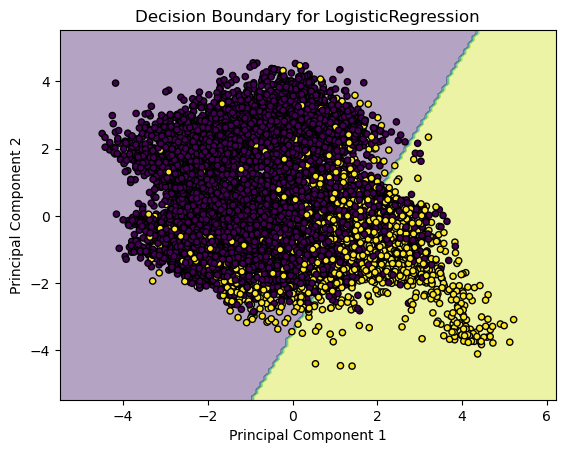

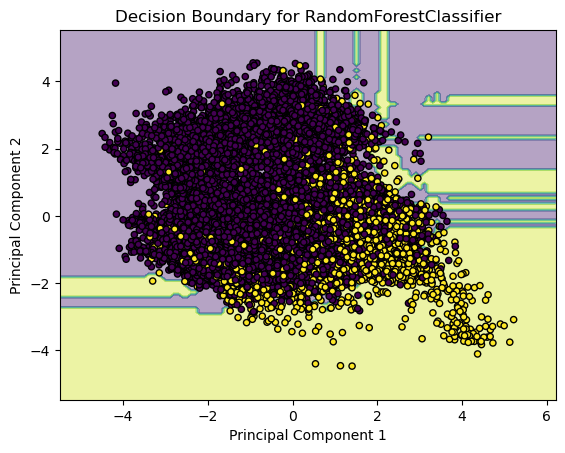

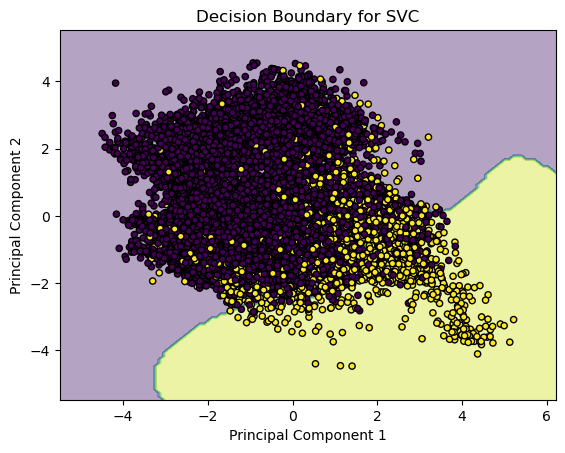

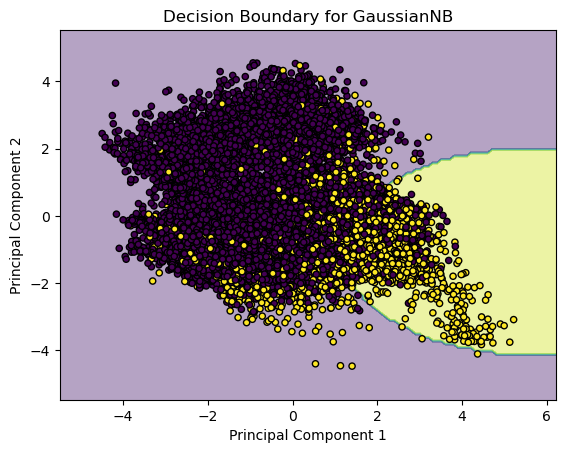

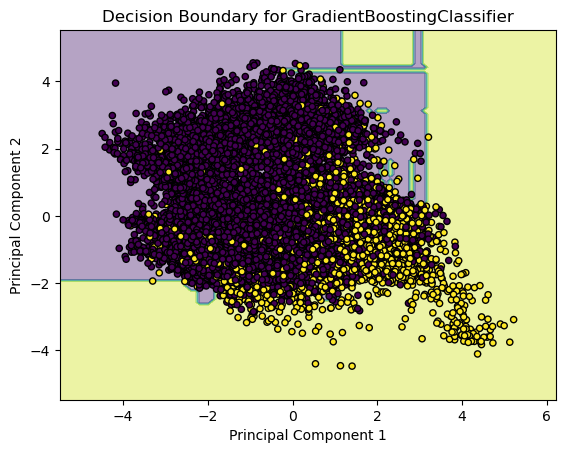

In [35]:
plotDecisionBoundary(adult_encoded, models)

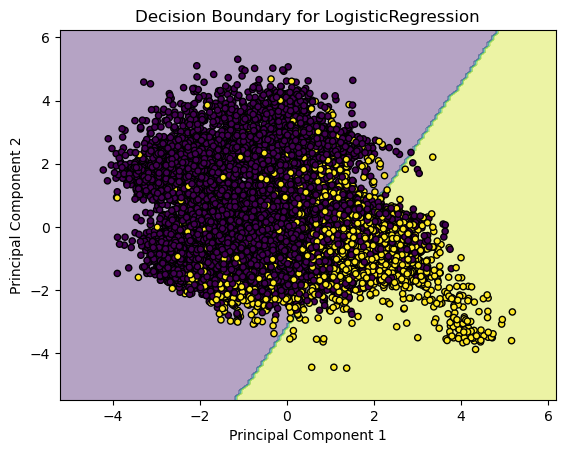

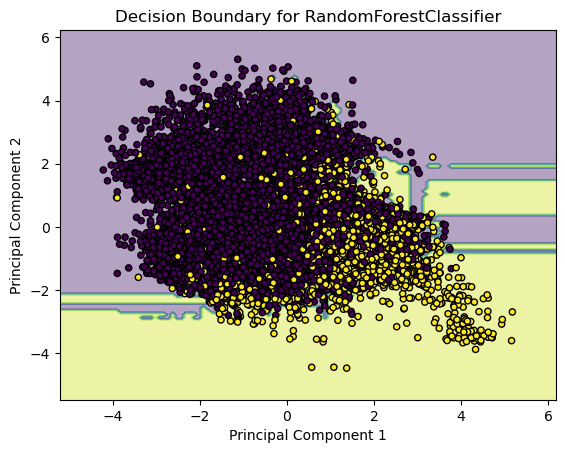

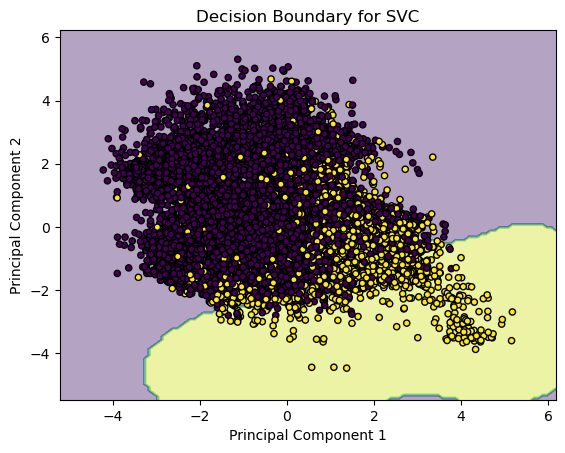

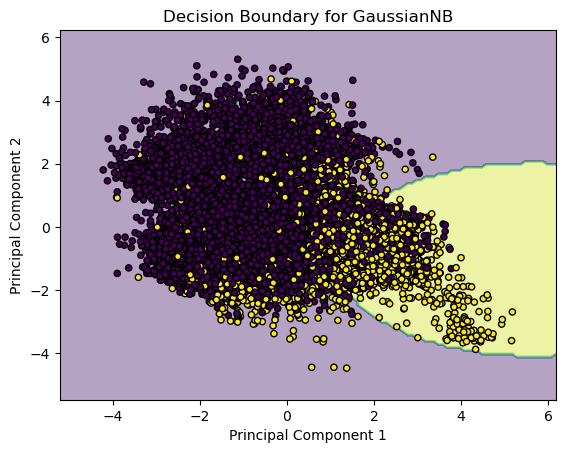

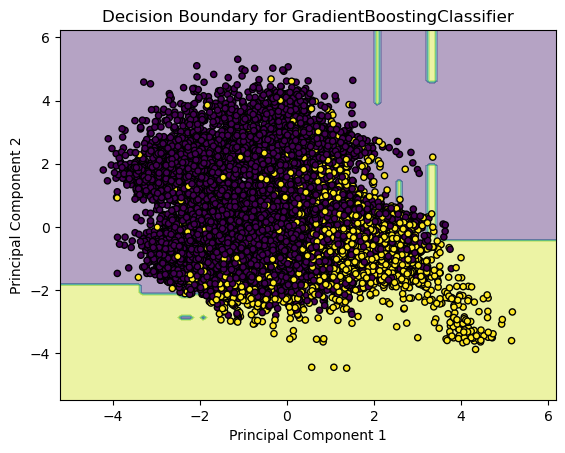

In [153]:
plotDecisionBoundary(adult_clean, models)

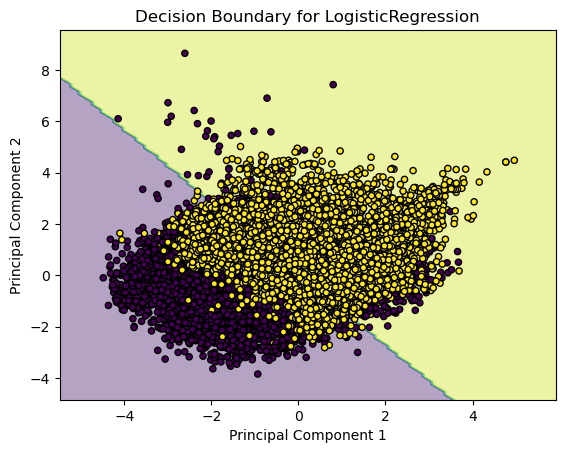

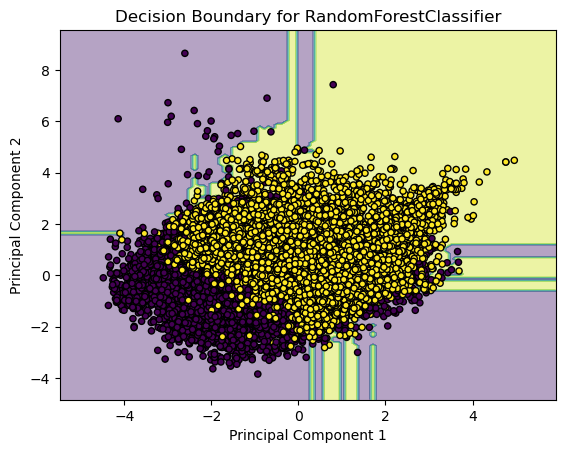

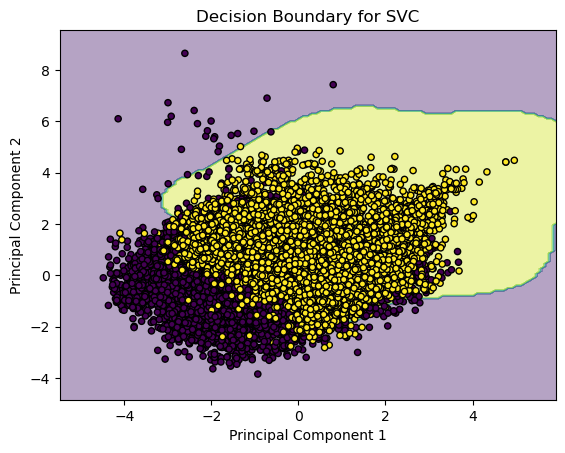

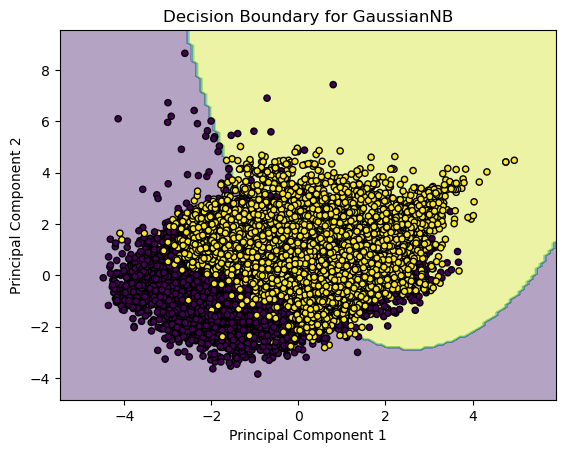

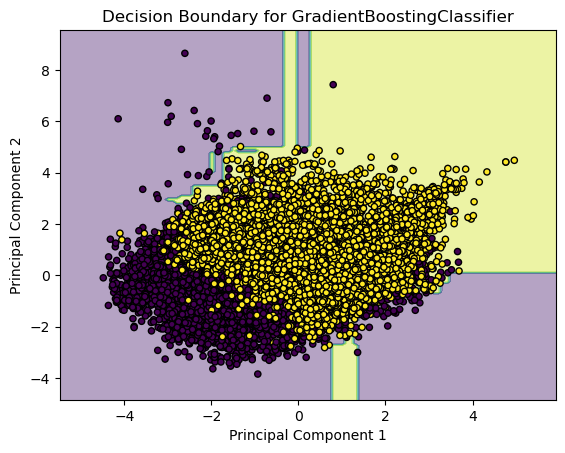

In [36]:
plotDecisionBoundary(adult_smote_drop, models)